In [41]:
!pip install -q --upgrade pip
!pip install -q --upgrade jupyter ipywidgets
!pip install -q --upgrade accelerate einops xformers
!pip install -q transformers datasets evaluate accelerate
!pip install -q tensorflow

  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.2.2+cpu requires torch==2.2.2, but you have torch 2.3.0 which is incompatible.
torchvision 0.17.2+cpu requires torch==2.2.2, but you have torch 2.3.0 which is incompatible.


In [43]:
!pip install -q torch==2.2.2 torchvision==0.17.2 torchaudio==2.2.2 --index-url https://download.pytorch.org/whl/cpu


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xformers 0.0.26.post1 requires torch==2.3.0, but you have torch 2.2.2+cpu which is incompatible.


In [1]:
# Get SSIC Fat table

import pandas as pd
import os

# Ingest & Convert SSIC Detailed Definition Doc into df
# Get current directory
current_dir = os.getcwd()

# Get parent directory
parent_dir = os.path.dirname(current_dir)

ssic_detailed_def_filename = "ssic2020-detailed-definitions.xlsx"
ssic_alpha_index_filename = "ssic2020-alphabetical-index.xlsx"

# Define the relative path to the CSV file
ssic_detailed_def_filepath = os.path.join(parent_dir, ssic_detailed_def_filename)
ssic_alpha_index_filepath = os.path.join(parent_dir, ssic_alpha_index_filename)

df_detailed_def = pd.read_excel(ssic_detailed_def_filepath, skiprows=4)
df_alpha_index = pd.read_excel(ssic_alpha_index_filepath, dtype=str, skiprows=5)
df_alpha_index = df_alpha_index.drop(df_alpha_index.columns[2], axis=1).dropna().rename(columns={'SSIC 2020': 'SSIC 2020','SSIC 2020 Alphabetical Index Description': 'Detailed Definitions'})

df = pd.concat([df_detailed_def, df_alpha_index])

# Prep SSIC ref-join tables
# Section, 1-alpha 
ssic_1_raw = df[df['SSIC 2020'].apply(lambda x: len(str(x)) == 1)].reset_index(drop=True).drop(columns=['Detailed Definitions', 'Cross References', 'Examples of Activities Classified Under this Code']) 
ssic_1_raw['Groups Classified Under this Code'] = ssic_1_raw['Groups Classified Under this Code'].str.split('\n•')
ssic_1 = ssic_1_raw.explode('Groups Classified Under this Code').reset_index(drop=True)
ssic_1['Groups Classified Under this Code'] = ssic_1['Groups Classified Under this Code'].str.replace('•', '')
ssic_1['Section, 2 digit code'] = ssic_1['Groups Classified Under this Code'].str[0:2]
ssic_1 = ssic_1.rename(columns={'SSIC 2020': 'Section','SSIC 2020 Title': 'Section Title'})

# Division, 2-digit
ssic_2_raw = df[df['SSIC 2020'].apply(lambda x: len(str(x)) == 2)].reset_index(drop=True).drop(columns=['Detailed Definitions', 'Cross References', 'Examples of Activities Classified Under this Code'])
ssic_2_raw['Groups Classified Under this Code'] = ssic_2_raw['Groups Classified Under this Code'].str.split('\n•')
ssic_2 = ssic_2_raw.explode('Groups Classified Under this Code').reset_index(drop=True)
ssic_2['Groups Classified Under this Code'] = ssic_2['Groups Classified Under this Code'].str.replace('•', '')
ssic_2 = ssic_2.rename(columns={'SSIC 2020': 'Division','SSIC 2020 Title': 'Division Title'}).drop(columns=['Groups Classified Under this Code']).drop_duplicates()

# Group, 3-digit 
ssic_3_raw = df[df['SSIC 2020'].apply(lambda x: len(str(x)) == 3)].reset_index(drop=True).drop(columns=['Detailed Definitions', 'Cross References', 'Examples of Activities Classified Under this Code'])
ssic_3_raw['Groups Classified Under this Code'] = ssic_3_raw['Groups Classified Under this Code'].str.split('\n•')
ssic_3 = ssic_3_raw.explode('Groups Classified Under this Code').reset_index(drop=True)
ssic_3['Groups Classified Under this Code'] = ssic_3['Groups Classified Under this Code'].str.replace('•', '')
ssic_3 = ssic_3.rename(columns={'SSIC 2020': 'Group','SSIC 2020 Title': 'Group Title'}).drop(columns=['Groups Classified Under this Code']).drop_duplicates()

# Class, 4-digit
ssic_4_raw = df[df['SSIC 2020'].apply(lambda x: len(str(x)) == 4)].reset_index(drop=True).drop(columns=['Detailed Definitions', 'Cross References', 'Examples of Activities Classified Under this Code'])
ssic_4_raw['Groups Classified Under this Code'] = ssic_4_raw['Groups Classified Under this Code'].str.split('\n•')
ssic_4 = ssic_4_raw.explode('Groups Classified Under this Code').reset_index(drop=True)
ssic_4['Groups Classified Under this Code'] = ssic_4['Groups Classified Under this Code'].str.replace('•', '')
ssic_4 = ssic_4.rename(columns={'SSIC 2020': 'Class','SSIC 2020 Title': 'Class Title'}).drop(columns=['Groups Classified Under this Code']).drop_duplicates()

# Sub-class, 5-digit
ssic_5 = df[df['SSIC 2020'].apply(lambda x: len(str(x)) == 5)].reset_index(drop=True).drop(columns=['Groups Classified Under this Code'])
ssic_5.replace('<Blank>', '', inplace=True)
ssic_5.replace('NaN', '', inplace=True)

# Prep join columns
ssic_5['Section, 2 digit code'] = ssic_5['SSIC 2020'].astype(str).str[:2]
ssic_5['Division'] = ssic_5['SSIC 2020'].astype(str).str[:2]
ssic_5['Group'] = ssic_5['SSIC 2020'].astype(str).str[:3]
ssic_5['Class'] = ssic_5['SSIC 2020'].astype(str).str[:4]

# Join ssic_5 to Hierarhical Layer Tables (Section, Division, Group, Class, Sub-Class)
ssic_df = pd.merge(ssic_5, ssic_1[['Section', 'Section Title', 'Section, 2 digit code']], on='Section, 2 digit code', how='left')
ssic_df = pd.merge(ssic_df, ssic_2[['Division', 'Division Title']], on='Division', how='left')
ssic_df = pd.merge(ssic_df, ssic_3[['Group', 'Group Title']], on='Group', how='left')
ssic_df = pd.merge(ssic_df, ssic_4[['Class', 'Class Title']], on='Class', how='left')


# ssic_df prep for model

# Inspect tables
# ssic_5.head(5)
ssic_df
# ssic_df.to_excel('SSIC Fact Ref Table.xlsx', index=False)

# # Query SSIC
# ssic_query_list = ['46900', '64202', '70201', '62011', '62021']
# filtered_df = ssic_df[ssic_df['SSIC 2020'].isin(ssic_query_list)]
# filtered_df.iloc[:, [0, 1, 9, 10, 11, 12, 13]].drop_duplicates()

C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\openpyxl\reader\workbook.py:118: UserWarning: Print area cannot be set to Defined name: 'SSIC2020 Detailed Definitions'!$A:$E.
  warn(f"Print area cannot be set to Defined name: {defn.value}.")
C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


,SSIC 2020,SSIC 2020 Title,Detailed Definitions,Cross References,Examples of Activities Classified Under this Code,"Section, 2 digit code",Division,Group,Class,Section,Section Title,Division Title,Group Title,Class Title
0,01111,Growing of leafy and fruit vegetables,This sub-class includes the cultivation of lea...,"•growing of mushrooms, see 01112\n•growing of ...",,01,01,011,0111,A,AGRICULTURE AND FISHING,AGRICULTURE AND RELATED SERVICE ACTIVITIES,"GROWING OF CROPS, MARKET GARDENING AND HORTICU...",Growing of Food Crops (Non-Hydroponics)
1,01112,Growing of mushrooms,This sub-class includes the cultivation of mus...,•growing of leafy and fruit vegetables (non-hy...,,01,01,011,0111,A,AGRICULTURE AND FISHING,AGRICULTURE AND RELATED SERVICE ACTIVITIES,"GROWING OF CROPS, MARKET GARDENING AND HORTICU...",Growing of Food Crops (Non-Hydroponics)
2,01113,Growing of root crops,This sub-class includes the cultivation of roo...,•growing of leafy and fruit vegetables (non-hy...,,01,01,011,0111,A,AGRICULTURE AND FISHING,AGRICULTURE AND RELATED SERVICE ACTIVITIES,"GROWING OF CROPS, MARKET GARDENING AND HORTICU...",Growing of Food Crops (Non-Hydroponics)
3,01119,Growing of food crops (non-hydroponics) n.e.c.,This sub-class includes the propagation of foo...,•growing of leafy and fruit vegetables (non-hy...,•cereals growing (non-hydroponics)\n•rice grow...,01,01,011,0111,A,AGRICULTURE AND FISHING,AGRICULTURE AND RELATED SERVICE ACTIVITIES,"GROWING OF CROPS, MARKET GARDENING AND HORTICU...",Growing of Food Crops (Non-Hydroponics)
4,01120,Growing of leafy and fruit vegetables (hydropo...,This sub-class includes the cultivation of lea...,•growing of leafy and fruit vegetables (non-hy...,,01,01,011,0112,A,AGRICULTURE AND FISHING,AGRICULTURE AND RELATED SERVICE ACTIVITIES,"GROWING OF CROPS, MARKET GARDENING AND HORTICU...",Growing of Food Crops (Hydroponics)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11842,97002,NaN,Employer of secretary (private household),NaN,NaN,97,97,970,9700,T,ACTIVITIES OF HOUSEHOLDS AS EMPLOYERS OF DOMES...,ACTIVITIES OF HOUSEHOLDS AS EMPLOYERS OF DOMES...,ACTIVITIES OF HOUSEHOLDS AS EMPLOYERS OF DOMES...,Activities of Households as Employers of Domes...
11843,99010,NaN,Foreign embassy,NaN,NaN,99,99,990,9901,U,ACTIVITIES OF EXTRA-TERRITORIAL ORGANISATIONS ...,ACTIVITIES OF EXTRA-TERRITORIAL ORGANISATIONS ...,ACTIVITIES OF EXTRA-TERRITORIAL ORGANISATIONS ...,Foreign Embassies and Trade Representative Off...
11844,99010,NaN,Foreign government trade representative office,NaN,NaN,99,99,990,9901,U,ACTIVITIES OF EXTRA-TERRITORIAL ORGANISATIONS ...,ACTIVITIES OF EXTRA-TERRITORIAL ORGANISATIONS ...,ACTIVITIES OF EXTRA-TERRITORIAL ORGANISATIONS ...,Foreign Embassies and Trade Representative Off...
11845,99020,NaN,Foreign armed force base,NaN,NaN,99,99,990,9902,U,ACTIVITIES OF EXTRA-TERRITORIAL ORGANISATIONS ...,ACTIVITIES OF EXTRA-TERRITORIAL ORGANISATIONS ...,ACTIVITIES OF EXTRA-TERRITORIAL ORGANISATIONS ...,Foreign Armed Forces


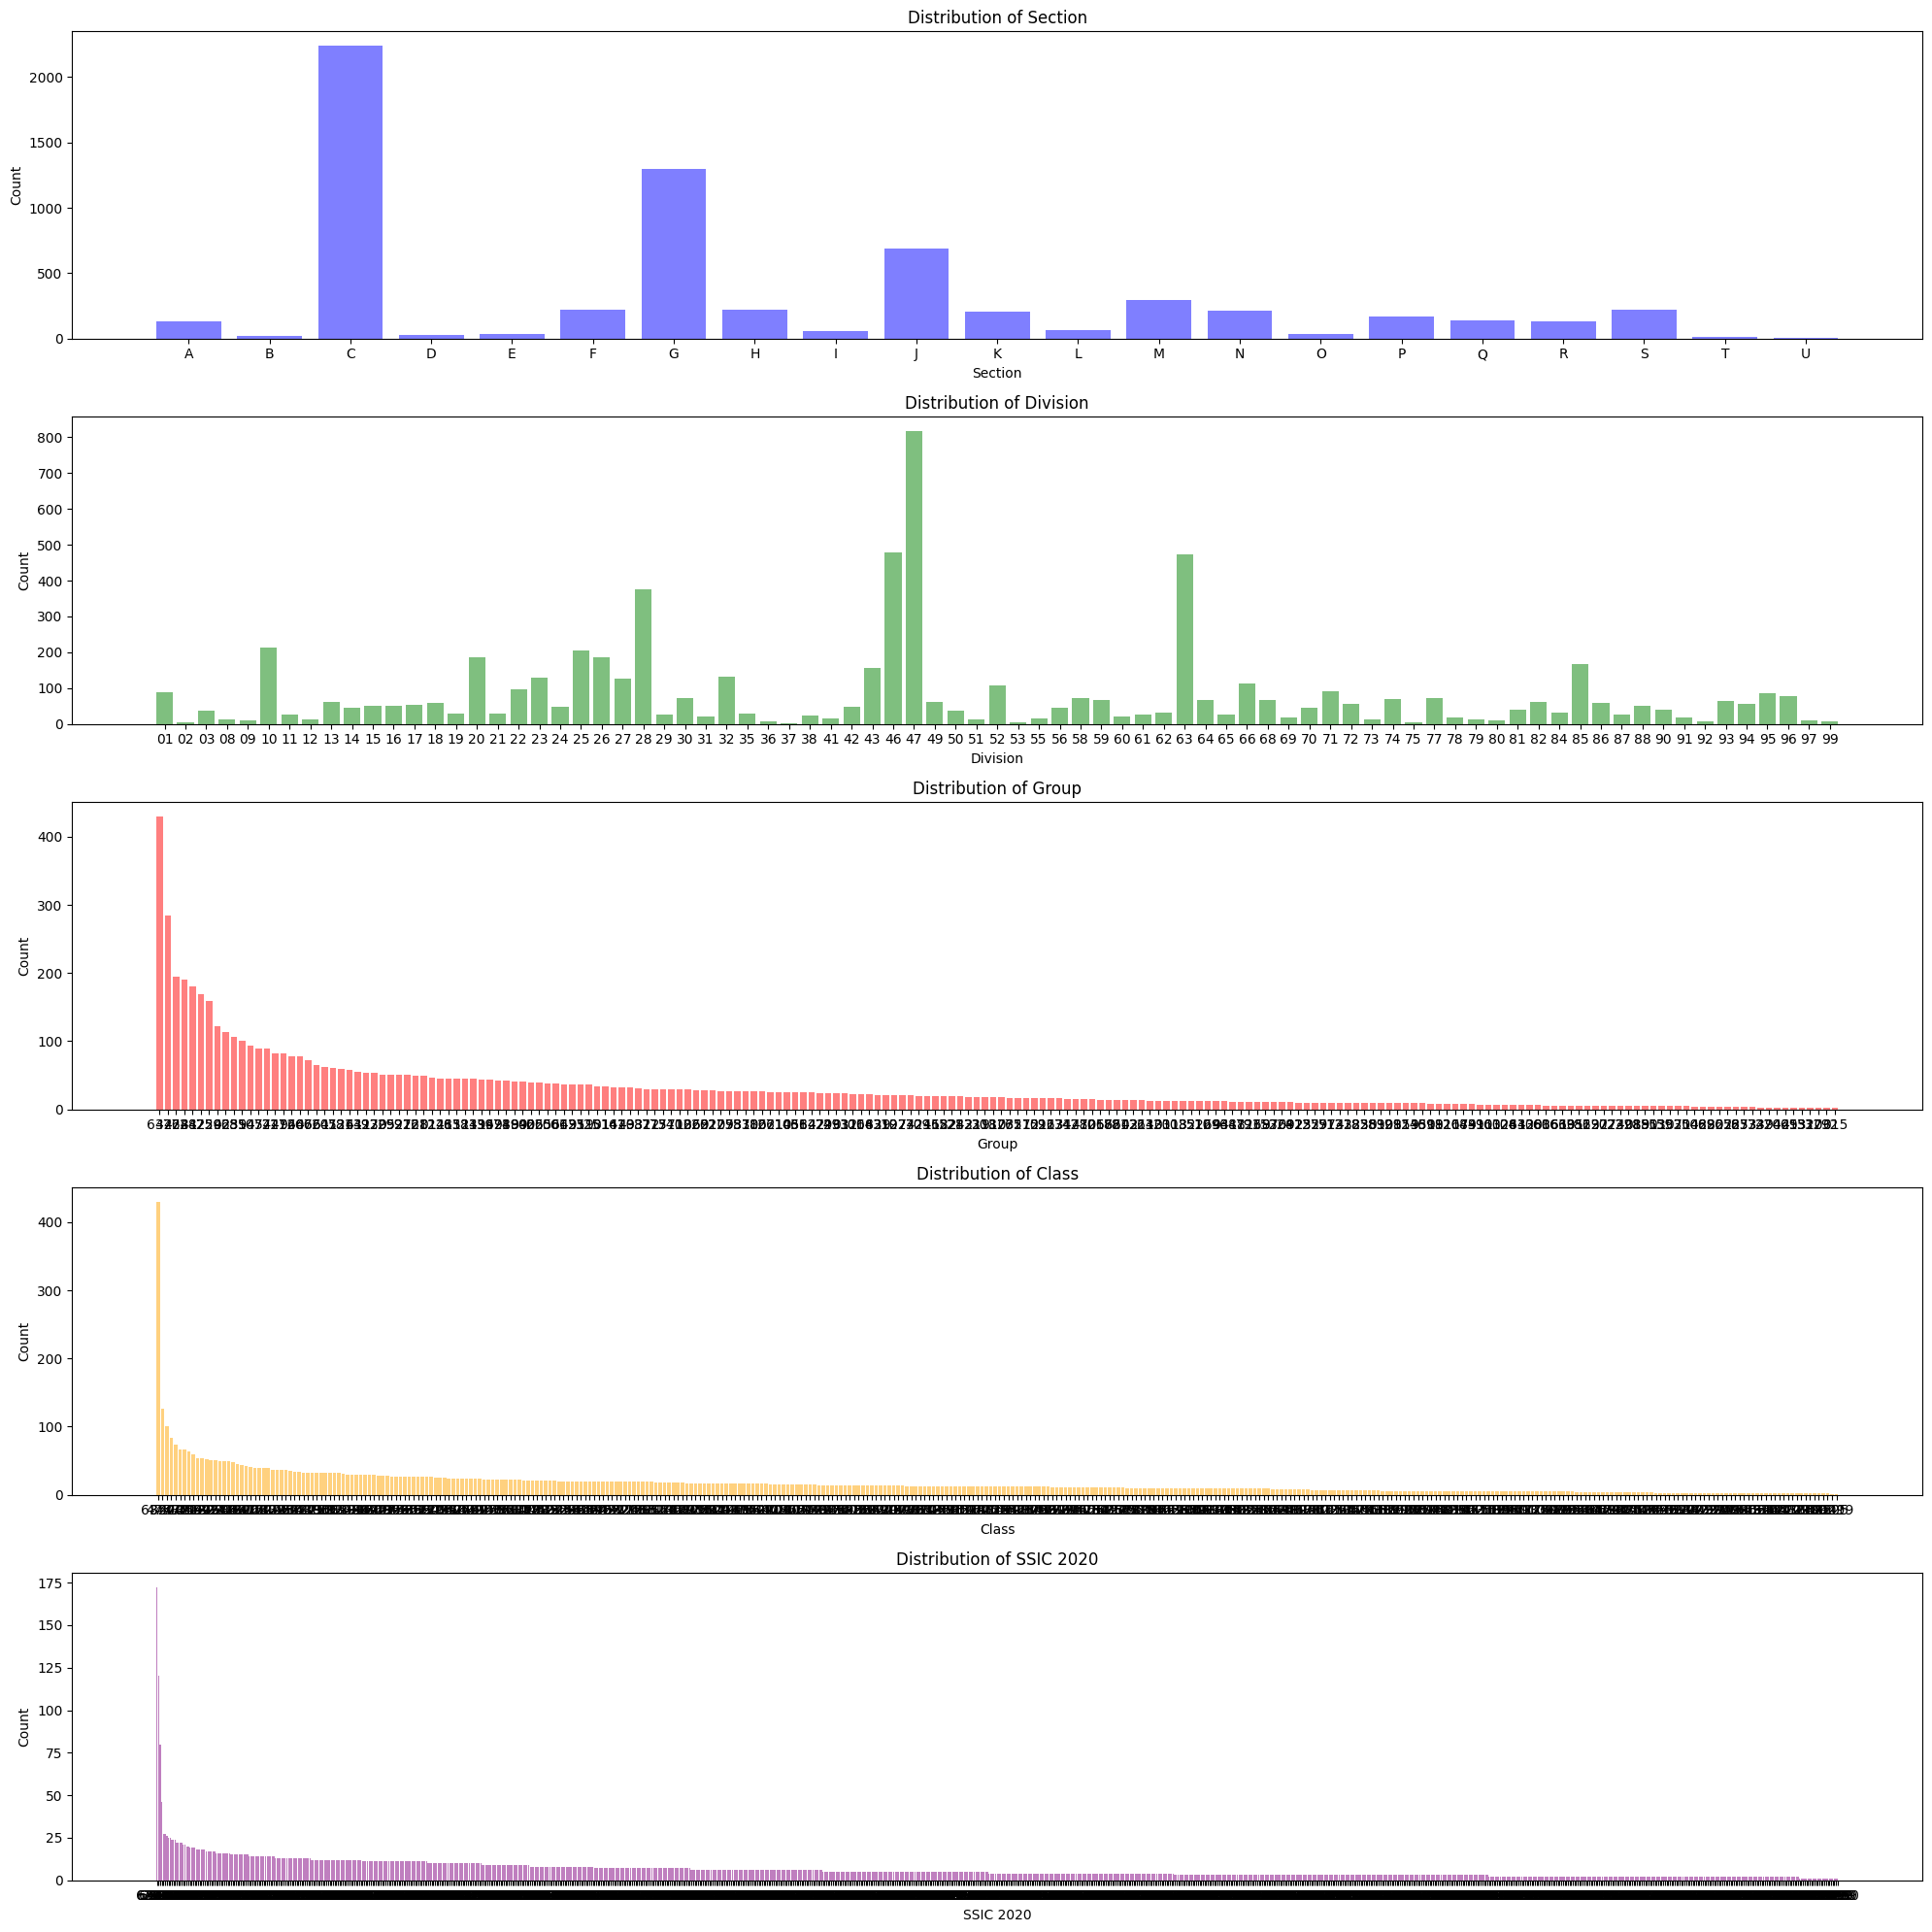

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Get count of each unique value in the 'Section' column
section_counts = ssic_df['Section'].value_counts().sort_index() # toggle .sort_index() for sorting by label or count
division_counts = ssic_df['Division'].value_counts().sort_index()
group_counts = ssic_df['Group'].value_counts()
class_counts = ssic_df['Class'].value_counts()
ssic_counts = ssic_df['SSIC 2020'].value_counts()

# Create subplots
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(20, 20))

# Plot each bar chart
axes[0].bar(section_counts.index, section_counts.values, alpha=0.5, color='blue')
axes[0].set_title('Distribution of Section')
axes[0].set_xlabel('Section')
axes[0].set_ylabel('Count')

axes[1].bar(division_counts.index, division_counts.values, alpha=0.5, color='green')
axes[1].set_title('Distribution of Division')
axes[1].set_xlabel('Division')
axes[1].set_ylabel('Count')

axes[2].bar(group_counts.index, group_counts.values, alpha=0.5, color='red')
axes[2].set_title('Distribution of Group')
axes[2].set_xlabel('Group')
axes[2].set_ylabel('Count')

axes[3].bar(class_counts.index, class_counts.values, alpha=0.5, color='orange')
axes[3].set_title('Distribution of Class')
axes[3].set_xlabel('Class')
axes[3].set_ylabel('Count')

axes[4].bar(ssic_counts.index, ssic_counts.values, alpha=0.5, color='purple')
axes[4].set_title('Distribution of SSIC 2020')
axes[4].set_xlabel('SSIC 2020')
axes[4].set_ylabel('Count')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [2]:
# df prep for model (Group)

df = ssic_df[['Group', 'Detailed Definitions']]
df['encoded_cat'] = df['Group'].astype('category').cat.codes

data_texts = df['Detailed Definitions'].to_list() # Features (not tokenized yet)
data_labels = df['encoded_cat'].to_list() # Labels

df.head(5)

C:\Users\royle\AppData\Local\Temp\ipykernel_19620\1652214702.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['encoded_cat'] = df['Group'].astype('category').cat.codes


,Group,Detailed Definitions,encoded_cat
0,011,This sub-class includes the cultivation of lea...,0
1,011,This sub-class includes the cultivation of mus...,0
2,011,This sub-class includes the cultivation of roo...,0
3,011,This sub-class includes the propagation of foo...,0
4,011,This sub-class includes the cultivation of lea...,0


In [202]:
# https://nilg.ai/202308/classifying-text-using-llms/

##################
# LLM DistilBert #
##################

# DistilBERT for Multiclass Text Classification Using Transformers - https://medium.com/@kiddojazz/distilbert-for-multiclass-text-classification-using-transformers-d6374e6678ba
# Hugging Face Link - https://huggingface.co/distilbert/distilbert-base-uncased

In [4]:
from sklearn.model_selection import train_test_split
 
# Split Train and Validation data
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size=0.2, random_state=0, shuffle=True)
 
# Keep some data for inference (testing)
train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size=0.01, random_state=0, shuffle=True)


In [4]:
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
import tensorflow as tf
import pandas as pd

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

RuntimeError: Failed to import transformers.models.distilbert.modeling_tf_distilbert because of the following error (look up to see its traceback):
[WinError 126] The specified module could not be found. Error loading "C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\lib\shm.dll" or one of its dependencies.

In [7]:
# Create TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings),train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings),val_labels))

# TFTrainer Class for Fine-tuning
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=204) # Indicate no. of labels/categories
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-08)
model.compile(optimizer=optimizer, loss=model.hf_compute_loss, metrics=['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [8]:
from tensorflow.keras.callbacks import EarlyStopping
 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
 
model.fit(train_dataset.shuffle(1000).batch(16),
epochs=2,
batch_size=16,
validation_data=val_dataset.shuffle(1000).batch(16),
callbacks=[early_stopping])

Epoch 1/2
319/319 [==============================] - 2352s 7s/step - loss: 3.8369 - accuracy: 0.2463 - val_loss: 2.6733 - val_accuracy: 0.4071
Epoch 2/2
319/319 [==============================] - 2374s 7s/step - loss: 2.0375 - accuracy: 0.5614 - val_loss: 1.5758 - val_accuracy: 0.6457


In [9]:
# Save model into folder w timestamp

from datetime import datetime
current_date = datetime.now().strftime("%d%m%y")

current_dir = os.getcwd()
# Define new folder name
new_folder_name = "distilBert Text Multiclass by 204 Groups caa " +  current_date

# Create the new folder path
new_folder_path = os.path.join(current_dir, new_folder_name)

# Create the new folder if it doesn't already exist
if not os.path.exists(new_folder_path):
    os.makedirs(new_folder_path)
    print(f"Folder '{new_folder_name}' created in {current_dir}")
else:
    print(f"Folder '{new_folder_name}' already exists in {current_dir}")

from tensorflow.keras.models import load_model
model.save_pretrained(new_folder_path)
tokenizer.save_pretrained(new_folder_path)

Folder 'distilBert Text Multiclass by 204 Groups caa 070624' created in c:\Users\royle\OneDrive\Documents\GitHub\ssicsync\LLM_Test


('c:\\Users\\royle\\OneDrive\\Documents\\GitHub\\ssicsync\\LLM_Test\\distilBert Text Multiclass by 204 Groups caa 070624\\tokenizer_config.json',
 'c:\\Users\\royle\\OneDrive\\Documents\\GitHub\\ssicsync\\LLM_Test\\distilBert Text Multiclass by 204 Groups caa 070624\\special_tokens_map.json',
 'c:\\Users\\royle\\OneDrive\\Documents\\GitHub\\ssicsync\\LLM_Test\\distilBert Text Multiclass by 204 Groups caa 070624\\vocab.txt',
 'c:\\Users\\royle\\OneDrive\\Documents\\GitHub\\ssicsync\\LLM_Test\\distilBert Text Multiclass by 204 Groups caa 070624\\added_tokens.json')

In [3]:
!pip install -q transformers datasets evaluate accelerate
!pip install -q tensorflow
!pip install -q torch==2.2.2 torchvision==0.17.2 torchaudio==2.2.2 --index-url https://download.pytorch.org/whl/cpu

# Load model and test

from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
import pandas as pd

save_directory = "distilBert Text Multiclass by 204 Groups caa 070624"
loaded_tokenizer = DistilBertTokenizer.from_pretrained(save_directory)
loaded_model = TFDistilBertForSequenceClassification.from_pretrained(save_directory)

# Remember to load these 2 cells!!!
# ssic_def prep for model
# df prep for model

RuntimeError: Failed to import transformers.models.distilbert.modeling_tf_distilbert because of the following error (look up to see its traceback):
[WinError 126] The specified module could not be found. Error loading "C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\lib\shm.dll" or one of its dependencies.

In [13]:
# Test

# specializes in the opening and management of diverse food outlets, aiming to create unique dining experiences while maintaining high standards of quality and service

# provides comprehensive Maintenance, Repair, and Overhaul (MRO) services for a wide range of aircraft, supported by a global network of facilities and strategic partnerships

# Singapore's regulatory authority overseeing business registration, financial reporting, and accounting standards, government

# Rakuten Group, Inc. is Japan's largest and the world's third-largest e-commerce company, offering diverse services from e-commerce to banking and professional sports, with global operations in Asia, Western Europe, and the Americas.

# boutique consultancy firm specializing in global real estate investments and wealth growth strategies

test_text = '''
provides comprehensive Maintenance, Repair, and Overhaul (MRO) services for a wide range of aircraft, supported by a global network of facilities and strategic partnerships
'''

from tensorflow.keras.models import load_model

predict_input = loaded_tokenizer.encode(test_text,
truncation=True,
padding=True,
return_tensors="tf")
 
output = loaded_model(predict_input)[0]

# Convert the output tensor to numpy array
output_array = output.numpy()
 
# Create a DataFrame from the output array
sorted_output_df = pd.DataFrame(output_array.T, columns=['Score']).sort_values(by='Score', ascending=False)
sorted_output_df.reset_index(inplace=True)

# Rename columns for clarity
sorted_output_df.columns = ['encoded_cat', 'Value']


# need to load ssic_df and df

section_dict = df[['Group', 'encoded_cat']].drop_duplicates()
ssic_1v = ssic_3[['Group', 'Group Title']].drop_duplicates()
merged_df = section_dict.merge(ssic_1v, on= 'Group', how='left')
merged_df2 = sorted_output_df.merge(merged_df, on = 'encoded_cat', how='left')

merged_df2[['Value', 'Group', 'Group Title']].head(5)

,Value,Group,Group Title
0,2.792274,522,SUPPORT ACTIVITIES FOR TRANSPORTATION
1,0.506017,500,WATER TRANSPORT
2,-0.057590,303,MANUFACTURE OF AIR AND SPACECRAFT AND RELATED ...
3,-0.479863,773,"RENTING AND LEASING OF OTHER MACHINERY, EQUIPM..."
4,-0.550261,492,OTHER LAND TRANSPORT


In [ ]:
##############
# LLM Setfit #
##############

# https://huggingface.co/blog/setfit
# https://huggingface.co/mcllstr/setfit-mltclss?text=3ZB+was+a+radio+station+based+in+Christchurch%2C+New+Zealand.+This+station+was+run+by+Radio+New+Zealand+%28formally+the+NZBS%2FNZBC%2FBCNZ%29+and+eventually+spawned+a+second+FM+station+called+B98FM.
# https://github.com/huggingface/setfit

In [ ]:
!pip install -q setfit

In [ ]:
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import SetFitModel, SetFitTrainer


In [ ]:
# Load SetFit model from Hub
model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2")

# Create trainer
trainer = SetFitTrainer(
    model=model,
    train_dataset= train_texts,
    eval_dataset=val_texts,
    loss_class=CosineSimilarityLoss,
    batch_size=16,
    num_iterations=20, # Number of text pairs to generate for contrastive learning
    num_epochs=1 # Number of epochs to use for contrastive learning
)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
C:\Users\royle\AppData\Local\Temp\ipykernel_14304\656820149.py:5: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


AttributeError: 'list' object has no attribute 'column_names'

In [ ]:
# train_texts, val_texts, train_labels, val_labels
# train_dataset
val_dataset


<_TensorSliceDataset element_spec=({'input_ids': TensorSpec(shape=(344,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(344,), dtype=tf.int32, name=None)}, TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [ ]:
# Load a dataset from the Hugging Face Hub
dataset = load_dataset("sst2")
dataset

C:\Users\royle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\urllib3\connection.py:407: DeprecationWarning: ssl.match_hostname() is deprecated
  match_hostname(cert, asserted_hostname)


DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 872
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 1821
    })
})

In [5]:
from transformers import pipeline

summarizer_facebook_bart = pipeline("summarization", model="facebook/bart-large-cnn") # https://huggingface.co/facebook/bart-large-cnn
summarizer_falconsai = pipeline("summarization", model="Falconsai/text_summarization") # https://huggingface.co/Falconsai/text_summarization
summarizer_azma_bart = pipeline("summarization", model="Azma-AI/bart-large-text-summarizer") # https://huggingface.co/Azma-AI/bart-large-text-summarizer

ARTICLE = """ 
The principal activities of the Company are the provision of airframe maintenance, component overhaul services and inventory
technical management, the provision of line maintenance and technical ground handling services and investment holdings.
The principal activities of the subsidiary companies are disclosed in Note 18 to the financial statements. There have been no
significant changes in the nature of these activities during the financial year.
"""
print(summarizer_facebook_bart(ARTICLE, max_length=60, min_length=30, do_sample=False))
print(summarizer_falconsai(ARTICLE, max_length=60, min_length=30, do_sample=False))
print(summarizer_azma_bart(ARTICLE, max_length=60, min_length=30, do_sample=False))

[{'summary_text': 'The principal activities of the subsidiary companies are disclosed in Note 18 to the financial statements. There have been no significant changes in the nature of these activities during the financial year.'}]
[{'summary_text': 'The principal activities of the subsidiary companies are disclosed in Note 18 to the financial statements . There have been no significant changes in the nature of these activities during the financial year .'}]
[{'summary_text': 'The principal activities of the Company are the provision of airframe maintenance, component overhaul services and inventory management. The subsidiary activities are disclosed in Note 18 to the financial statements.'}]


In [6]:
from transformers import pipeline, AutoTokenizer
import torch

torch.manual_seed(0)
model = "tiiuae/falcon-7b-instruct"

tokenizer = AutoTokenizer.from_pretrained(model)
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
torch.manual_seed(3)
prompt = """Permaculture is a design process mimicking the diversity, functionality and resilience of natural ecosystems. The principles and practices are drawn from traditional ecological knowledge of indigenous cultures combined with modern scientific understanding and technological innovations. Permaculture design provides a framework helping individuals and communities develop innovative, creative and effective strategies for meeting basic needs while preparing for and mitigating the projected impacts of climate change.
Write a summary of the above text.
Summary:
"""

sequences = pipe(
    prompt,
    max_new_tokens=30,
    do_sample=True,
    top_k=10,
    return_full_text = False,
)

for seq in sequences:
    print(f"{seq['generated_text']}")

Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
The current implementation of Falcon calls `torch.scaled_dot_product_attention` directly, this will be deprecated in the future in favor of the `BetterTransformer` API. Please install the latest optimum library with `pip install -U optimum` and call `model.to_bettertransformer()` to benefit from `torch.scaled_dot_product_attention` and future performance optimizations.


KeyboardInterrupt: 